<a href="https://colab.research.google.com/github/siddharthpaul2005/Weatherapp/blob/main/face_recognisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import cv2
import numpy as np

#  Set dataset path
dataset_path = "/content/drive/MyDrive/face_recognisation"

if os.path.exists(dataset_path):
    print(" The data sethas been found!")
    print(os.listdir(dataset_path))
else:
    print(" Dataset NOT found! Check your path.")


Mounted at /content/drive
 The data sethas been found!
['README', 's9', 's40', 's5', 's39', 's8', 's7', 's6', 's37', 's38', 's4', 's36', 's35', 's32', 's31', 's29', 's28', 's3', 's34', 's30', 's33', 's27', 's26', 's20', 's18', 's21', 's2', 's19', 's24', 's22', 's25', 's23', 's17', 's15', 's16', 's12', 's11', 's10', 's13', 's1', 's14']


In [ ]:
def load_images(directory):
    images = []
    labels = []
    label_dict = {}  # Maps label id → folder name

    subfolders = sorted(os.listdir(directory))  # s1, s2, ...
    for label_id, folder in enumerate(subfolders):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            label_dict[label_id] = folder
            for image_name in os.listdir(folder_path):
                if image_name.endswith('.pgm'):
                    image_path = os.path.join(folder_path, image_name)
                    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (100, 100))
                    images.append(img.flatten())
                    labels.append(label_id)
    return np.array(images), np.array(labels), label_dict


In [ ]:
def compute_pca(images, num_components=50):
    mean_face = np.mean(images, axis=0)
    centered_images = images - mean_face

    L = np.dot(centered_images, centered_images.T)
    eigenvalues, eigenvectors_small = np.linalg.eigh(L)

    idx = np.argsort(-eigenvalues)
    eigenvalues = eigenvalues[idx]
    eigenvectors_small = eigenvectors_small[:, idx]

    eigenvectors = np.dot(centered_images.T, eigenvectors_small)
    eigenfaces = eigenvectors[:, :num_components]

    for i in range(eigenfaces.shape[1]):
        eigenfaces[:, i] /= np.linalg.norm(eigenfaces[:, i])

    return mean_face, eigenfaces


In [ ]:
def project_face(image, mean_face, eigenfaces):
    return np.dot(eigenfaces.T, (image - mean_face))


In [ ]:
def predict_face(image, mean_face, eigenfaces, images, labels, label_dict, threshold=3000):
    image = cv2.resize(image, (100, 100)).flatten()
    projected_test = project_face(image, mean_face, eigenfaces)
    projected_train = np.dot(images - mean_face, eigenfaces)

    distances = np.linalg.norm(projected_train - projected_test, axis=1)
    best_match = np.argmin(distances)
    best_distance = distances[best_match]

    print(f" Best Match Distance: {best_distance:.2f}")

    if best_distance < threshold:
        return label_dict[labels[best_match]], best_distance
    else:
        return "Unknown", best_distance


In [ ]:
import matplotlib.pyplot as plt

def show_result(image, label, distance):
    plt.imshow(image, cmap='gray')
    plt.title(f"Prediction: {label} (Distance: {distance:.2f})")
    plt.axis('off')
    plt.show()


In [ ]:
images, labels, label_dict = load_images(dataset_path)
mean_face, eigenfaces = compute_pca(images)


Saving images (5).jpg to images (5) (1).jpg
 Best Match Distance: 3926.22


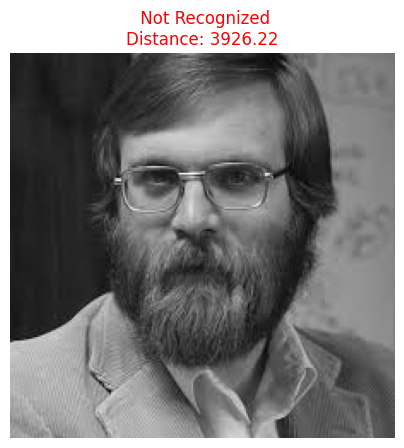

In [ ]:
def show_result(image, label, distance, threshold=10000):
    plt.figure(figsize=(5,5))
    plt.imshow(image, cmap='gray')

    if label == "Unknown" or distance > threshold:
        title_color = 'red'
        message = f" Not Recognized\nDistance: {distance:.2f}"
    else:
        title_color = 'green'
        message = f" Recognized: {label}\nDistance: {distance:.2f}"

    plt.title(message, color=title_color, fontsize=12)
    plt.axis('off')
    plt.show()


from google.colab import files
uploaded = files.upload()

for fname in uploaded.keys():
  test_img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
  result, dist = predict_face(test_img, mean_face, eigenfaces, images, labels, label_dict)
  show_result(test_img, result, dist)  #  Now displays clear label & message

